In [0]:
import pandas as pd
import numpy as np
#data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from PIL import Image
import seaborn as sns
#For statistics
from scipy import stats
from scipy.stats import kurtosis, skew, norm
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
import researchpy as rp
import os;

#modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics
from sklearn.decomposition import PCA
#making sure floats output to 3 decimal points only
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
#Timer for run time
from timeit import default_timer as timer
#Ignore warning from sklearn and seaborn
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


//anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
#uploaded = files.upload()
def change_working_dir(path):
    os.chdir(path)
    print("Current working directory:{}".format(str(os.getcwd())))
    
WORKING_DIRECTORY_PATH = '/Users/ab2772/Downloads/digit-recognizer'
   
change_working_dir(WORKING_DIRECTORY_PATH)

Current working directory:/Users/ab2772/Downloads/digit-recognizer


In [0]:
def plot_images(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [0]:
def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    X_normalized = MinMaxScaler().fit_transform(X)
    
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

In [0]:
def cross_val(model, train, target, fold, scoring):
    scores = cross_validate(model, train, target, cv = fold, scoring = {scoring})
    #Cross validation scores
    scores_df = pd.DataFrame(scores).iloc[:,2:]
    scores_df.columns.names=['cross_validation']
    return scores_df

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### RFC with No Decomp:

In [0]:
# Using unscaled data for evaluation as Random Forests are scale invariant
y_train = train['label'].values
X_train = train.drop(columns=['label'])
X_train = X_train.to_numpy()
X_test = test.to_numpy()

In [0]:
rnd_clf = RandomForestClassifier(n_estimators=10, max_features='sqrt', bootstrap=True, random_state=1, n_jobs=-1)
start = timer()
rnd_clf.fit(X_train, y_train)
end = timer()
execution_time = (end-start)
print('Execution Time in Sec:', execution_time)

Execution Time in Sec: 0.7740669780000005


In [0]:
y_pred = cross_val_predict(rnd_clf, X_train, y_train, cv=10)

In [0]:
print(train.keys())
print('Classification Report with No Decomposition:')
print(metrics.classification_report(y_train, y_pred), '\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_train, y_pred))

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
Classification Report with No Decomposition:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4132
           1       0.97      0.98      0.98      4684
           2       0.93      0.95      0.94      4177
           3       0.91      0.92      0.92      4351
           4       0.93      0.95      0.94      4072
           5       0.92      0.91      0.92      3795
           6       0.96      0.96      0.96      4137
           7       0.96      0.95      0.95      4401
           8       0.94      0.89      0.91      4063
           9       0.93      0.91      0.92      4188

    accuracy                           0.94     42000
   macro avg

In [0]:
submission = rnd_clf.predict(X_test)
submission = pd.DataFrame(submission, columns=['Label'])
submission.index = np.arange(1,len(submission)+1)
submission.reset_index(inplace=True)
submission.rename(columns={'index':'ImageId'}, inplace=True)
submission.to_csv('submission_v2.csv', index=False)

### Score round 1:
#### User name: abehzad, Kaggle Score: 0.942

### RFC Using PCA:

In [0]:
pca = PCA(n_components=0.95, random_state=1)
start = timer()
X_train_reduced = pca.fit_transform(X_train)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 2.820127577000001


In [0]:
pca.n_components_

154

In [0]:
np.sum(pca.explained_variance_ratio_)

0.9504332382633768

In [0]:
rnd_clf2 = RandomForestClassifier(n_estimators=10, max_features='sqrt', bootstrap=True, random_state=1, n_jobs=-1)
start = timer()
rnd_clf2.fit(X_train_reduced, y_train)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 1.6858932160000037


In [0]:
y_pred2 = cross_val_predict(rnd_clf2, X_train_reduced, y_train, cv=10)

In [0]:
print(test.keys())
print('Classification Report with PCA Decomposition:')
print(metrics.classification_report(y_train, y_pred2), '\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_train, y_pred2))

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)
Classification Report with PCA Decomposition:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      4132
           1       0.96      0.97      0.97      4684
           2       0.84      0.89      0.86      4177
           3       0.81      0.86      0.84      4351
           4       0.84      0.89      0.87      4072
           5       0.84      0.80      0.82      3795
           6       0.94      0.92      0.93      4137
           7       0.92      0.89      0.90      4401
           8       0.88      0.77      0.82      4063
           9       0.88      0.82      0.85      4188

    accuracy                           0.88     42000
   macro a

In [0]:
X_test_reduced = pca.transform(X_test)

In [0]:
submission2 = rnd_clf2.predict(X_test_reduced)
submission2 = pd.DataFrame(submission2, columns=['Label'])
submission2.index = np.arange(1,len(submission2)+1)
submission2.reset_index(inplace=True)
submission2.rename(columns={'index':'ImageId'}, inplace=True)
submission2.to_csv('submission2.csv', index=False)

### Score round 2:
#### User name: abehzad, Kaggle Score: 0.876

### Identify Major Design Flaw Using EDA:
 - Employing a Random Forest Classifier with PCA decomposition produced significantly worse results.
 - In this section, PCA decomposition will be further explored to understand why were substantially different.
 - PCA will be compared with other dimensionality reduction methods to see if there are other alternatives that would provide better results.

#### Image Comparison Between Original and PCA Transformed Data:
 - Reverting back the PCA transformed data to the original shows that there is a difference, yet they are not as significant.

In [0]:
X_recovered = pca.inverse_transform(X_train_reduced) 

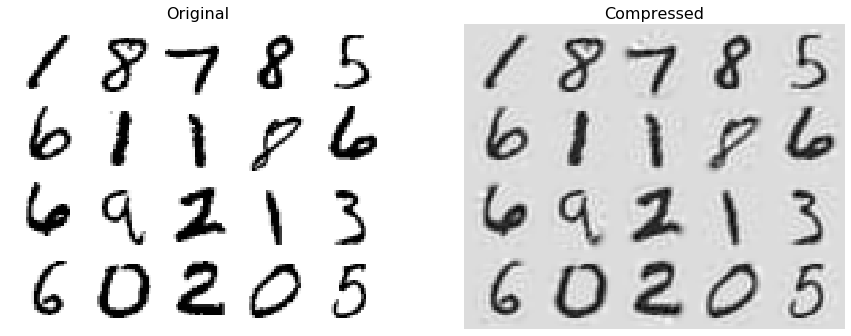

In [0]:
plt.figure(figsize=(15, 12))
plt.subplot(121)
plot_images(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_images(X_recovered[::2100])
plt.title("Compressed", fontsize=16)
plt.savefig("mnist_compression_plot")
plt.show();

#### PCA Visualization of of Clusters Based on Two Components:
 - 2 components are used as using all components are difficult to plot.
 - Visualization shows that although there are a few clusters, there is significant overlap.
 - PCA is a linear algorithm. Thus, it will not be able to interpret complex polynomial relationships between features.
 - A major problem with, linear dimensionality reduction algorithms is that they concentrate on placing dissimilar data points far apart in a lower dimension representation.
 - But in order to represent high dimension data on low dimension, non-linear manifold, it is important that similar datapoints must be represented close together, which is not what linear dimensionality reduction algorithms do.
 - This may be the likely reason why the results were suboptimal.

In [0]:
pca_eda = PCA(n_components=2, random_state=1)
X_reduced_2 = pca_eda.fit_transform(X_train)

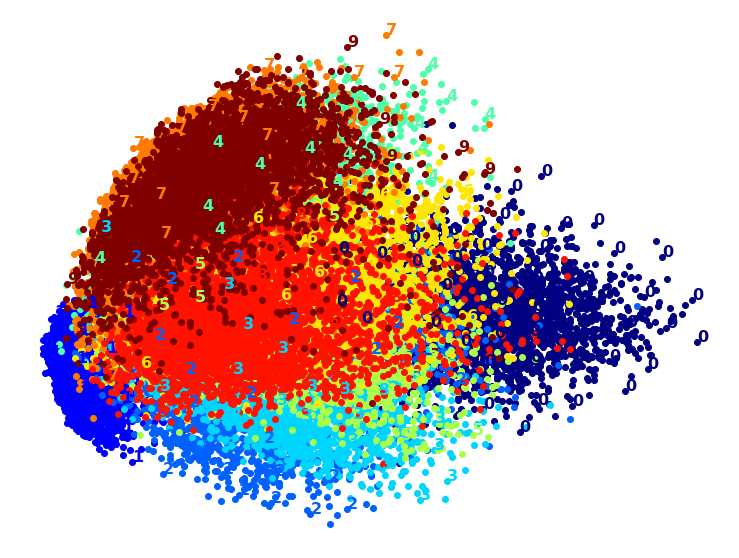

In [0]:
plot_digits(X_reduced_2, y_train)

In [0]:
from sklearn.manifold import TSNE

X_tsne_reduced = TSNE(n_components=2, random_state=1).fit_transform(X_train)


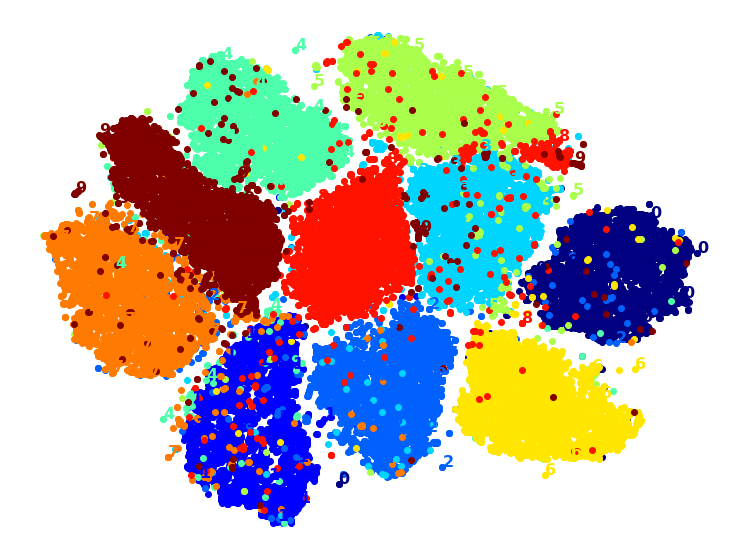

In [0]:
plot_digits(X_tsne_reduced, y_train)


In [0]:
pca_tsne = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=1)),
    ('tsne', TSNE(n_components=2, random_state=1)),
])
start = timer()
X_pca_tsne_reduced = pca_tsne.fit_transform(X_train)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 1000.4579540249997


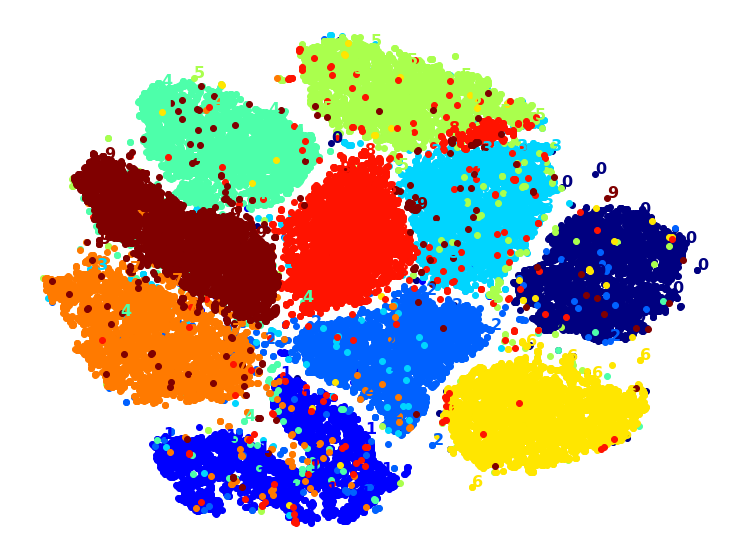

In [0]:
plot_digits(X_pca_tsne_reduced, y_train)

In [0]:
from sklearn.decomposition import KernelPCA
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced_rbf = rbf_pca.fit_transform(X_train)

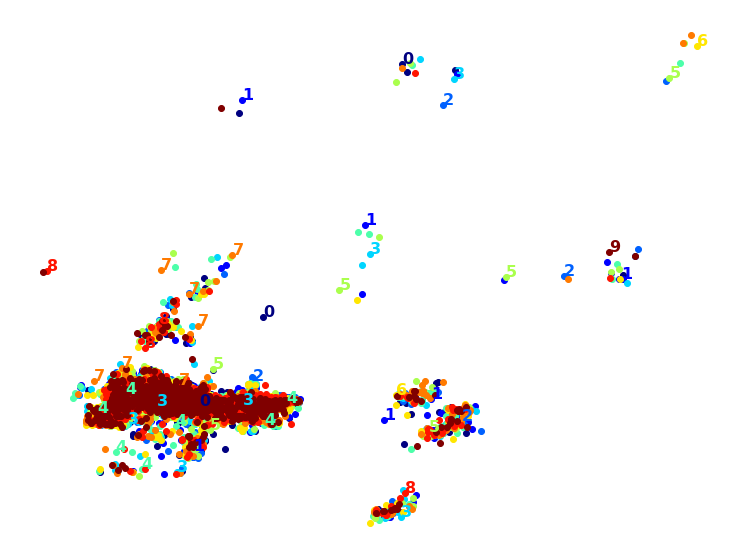

In [0]:
plot_digits(X_reduced_rbf, y_train)

In [0]:
n_components_array=([1,2,3,4,5,10,20,50,154,200])
vr = np.zeros(len(n_components_array))
i=0;
for n_components in n_components_array:
    pca_plot = PCA(n_components=n_components, random_state=1)
    pca_plot.fit(X_train)
    vr[i] = sum(pca_plot.explained_variance_ratio_)
    i=i+1 

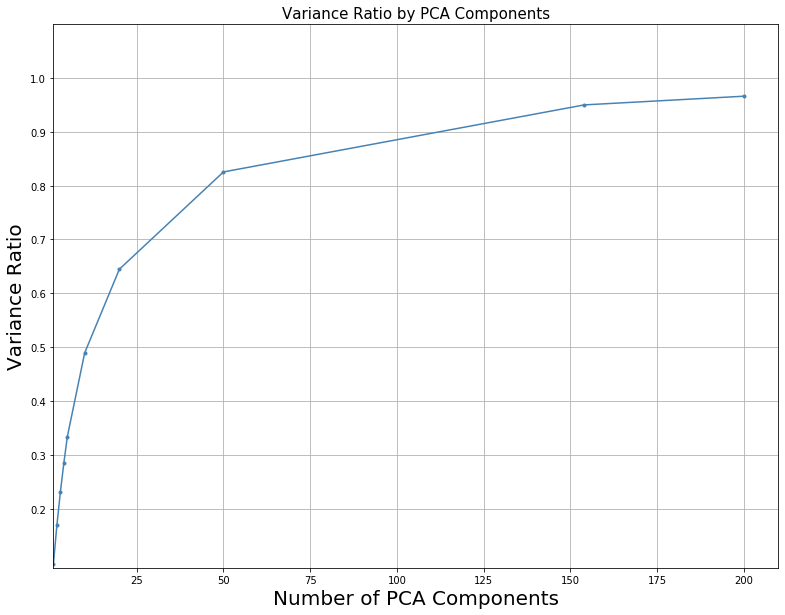

In [0]:
figure(figsize(13,10))
plot(n_components_array,vr,'k.-', color='steelblue')
ylim(9e-2,1.1)
yticks(linspace(0.2,1.0,9))
xlim(0.9)
grid(which='both')
xlabel("Number of PCA Components",size=20)
ylabel("Variance Ratio",size=20)
plt.title('Variance Ratio by PCA Components', fontsize=15)
plt.savefig('Variance Ratio by PCA Components')
plt.show();

In [0]:
from sklearn.model_selection import train_test_split
def evaluate_classifier(clf, data, target, split_ratio):
    trainX, testX, trainY, testY = train_test_split(data, target, train_size=split_ratio, random_state=1)
    clf.fit(trainX, trainY)
    return clf.score(testX,testY)

In [0]:
eval_rnd_clf = RandomForestClassifier(n_estimators=10, max_features='sqrt', bootstrap=True, random_state=1, n_jobs=-1)
n_components_array=([1,2,3,4,5,10,20,50,154,200])
score_array = np.zeros(len(n_components_array))
i=0

for n_components in n_components_array:
    pca_acc = PCA(n_components=n_components, random_state=1)
    pca_acc.fit(X_train)
    transform = pca_acc.transform(X_train)
    score_array[i] = evaluate_classifier(eval_rnd_clf, transform, y_train, 0.8)
    i=i+1

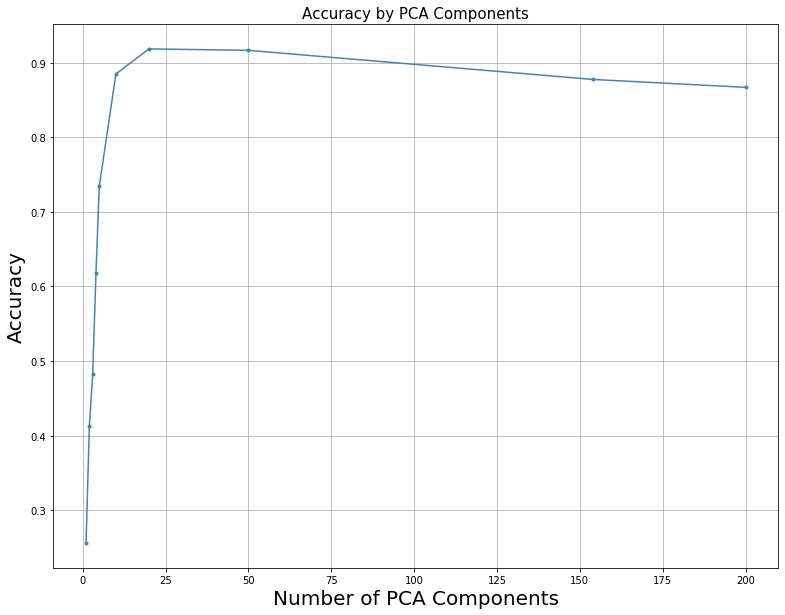

In [0]:
figure(figsize(13, 10))
plot(n_components_array,score_array,'k.-', color='steelblue')
xlabel("Number of PCA Components", size=20)
ylabel("Accuracy", size=20)
grid(which="both")
plt.title('Accuracy by PCA Components', fontsize=15)
plt.savefig('Accuracy by PCA Components')
plt.show();

### PCA Decomposition with Reduced Variance Using Gridsearch to Find Best Parameter:

In [0]:
pca_pipe = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=1)),
    ('rfc', RandomForestClassifier(n_estimators=10, max_features='sqrt', bootstrap=True, random_state=1, n_jobs=-1)),
])

In [0]:
pca_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=1, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('rfc',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='sqrt',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=-1,
                                        oob_score=False, random_state=1,
                                        verbose=0, warm_sta

In [0]:
param_grid = dict(pca__n_components=range(1, 154))
grid_clf = GridSearchCV(pca_pipe, param_grid, cv=10, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 10 folds for each of 153 candidates, totalling 1530 fits
[CV] pca__n_components=1 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. pca__n_components=1, total=   3.6s
[CV] pca__n_components=1 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] .............................. pca__n_components=1, total=   1.7s
[CV] pca__n_components=1 .............................................
[CV] .............................. pca__n_components=1, total=   1.7s
[CV] pca__n_components=1 .............................................
[CV] .............................. pca__n_components=1, total=   1.7s
[CV] pca__n_components=1 .............................................
[CV] .............................. pca__n_components=1, total=   1.7s
[CV] pca__n_components=1 .............................................
[CV] .............................. pca__n_components=1, total=   1.7s
[CV] pca__n_components=1 .............................................
[CV] .............................. pca__n_components=1, total=   1.7s
[CV] pca__n_components=1 .............................................
[CV] .............................. pca__n_components=1, total=   1.7s
[CV] pca__n_components=1 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done 1530 out of 1530 | elapsed: 76.4min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=0.95, random_state=1,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='sqrt',
                                                               max_leaf_nodes=None,
                              

In [0]:
grid_clf.best_params_

{'pca__n_components': 27}

In [0]:
grid_clf.score(X_train, y_train)

0.9985238095238095

In [0]:
pca_best = PCA(n_components=27, random_state=1)
start = timer()
X_train_best = pca_best.fit_transform(X_train)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 1.1598214779987757


In [0]:
np.sum(pca_best.explained_variance_ratio_)

0.7098038631523463

In [0]:
rnd_clf3 = RandomForestClassifier(n_estimators=10, max_features='sqrt', bootstrap=True, random_state=1, n_jobs=-1)
start = timer()
rnd_clf3.fit(X_train_best, y_train)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 0.6520878070004983


In [0]:
y_pred3 = cross_val_predict(rnd_clf3, X_train_best, y_train, cv=10)

In [0]:
print('Classification Report with PCA Decomposition (Reduced Variance Ratio to 0.71):')
print(metrics.classification_report(y_train, y_pred3), '\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_train, y_pred3))

Classification Report with PCA Decomposition (Reduced Variance Ratio to 0.71):
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      4132
           1       0.97      0.98      0.97      4684
           2       0.90      0.93      0.91      4177
           3       0.89      0.90      0.90      4351
           4       0.89      0.92      0.91      4072
           5       0.90      0.89      0.89      3795
           6       0.95      0.95      0.95      4137
           7       0.94      0.93      0.93      4401
           8       0.91      0.86      0.89      4063
           9       0.90      0.86      0.88      4188

    accuracy                           0.92     42000
   macro avg       0.92      0.92      0.92     42000
weighted avg       0.92      0.92      0.92     42000
 

Confusion Matrix:
[[4004    0   19   22    7   16   38    4   16    6]
 [   2 4577   35   17    6   12    8   10   14    3]
 [  34   15 3879   52   34    8   30

In [0]:
X_test_best = pca_best.transform(X_test)

In [0]:
submission3 = rnd_clf3.predict(X_test_best)
submission3 = pd.DataFrame(submission3, columns=['Label'])
submission3.index = np.arange(1,len(submission3)+1)
submission3.reset_index(inplace=True)
submission3.rename(columns={'index':'ImageId'}, inplace=True)
submission3.to_csv('submission3.csv', index=False)

### Score:

#### User name: abehzad , Kaggle Score: 0.919